# Store Demand Forecast
## Introduction
This project is a form of practice for another project using the prophet model.

I was encountering a lot of problems with that project with the njupyter notebook crashing, timeouts, etc.

Hopefully I get to explore how to use the prophet model a little better here before troubleshooting there.

## The Dataset
The dataset can be found here: [https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data)

Breakdown of the dataset columns:
* date: date of the sale data. No holiday effects or store closures.
* store: store ID
* item: item ID
* sales: Number of items sold at the particular store on a particular date




## Data Cleaning
Let's take a look if there's any need to clean/transform.

In [1]:
# import the relevant libraries
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns

# importing time to check elapsed time
import time

# import prophet model
from prophet import Prophet

# importing some metrics calculation tools
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# extra step for google collab to import files
#from google.colab import drive
#drive.mount('/content/gdrive')

In [2]:
# importing the zip file
df = pd.read_csv('dataset/train.csv.zip', compression='zip', sep=',')

In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
# changing date from an object dtype to a datetime64 dtype
df['date'] = df['date'].astype('datetime64[ns]') # this will keep the data up until the nanosecond level

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [8]:
df.describe()

,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [9]:
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

No NaN. This is good.

In [10]:
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

From the output above we can deduce that there are:
1. 1826 dates (or days in this case) - so about 5 years
2. 10 unique stores
3. 50 unique items for each store

In [11]:
# checking for duplicate date, store, item
df[df.duplicated(subset=['date', 'store', 'item'], keep=False)].shape

(0, 4)

In [12]:
# meaning there shouldn't be any duplicated rows in general too
df[df.duplicated(keep=False)].shape

(0, 4)

This is good. No duplicated rows.

## Data Exploration

In [13]:
# let's see how the mean sales for all stores together looks like across time
mean_sales = df.groupby('date')['sales'].mean()

In [14]:
mean_sales.head()

date
2013-01-01    27.392
2013-01-02    27.356
2013-01-03    28.976
2013-01-04    31.354
2013-01-05    32.474
Name: sales, dtype: float64

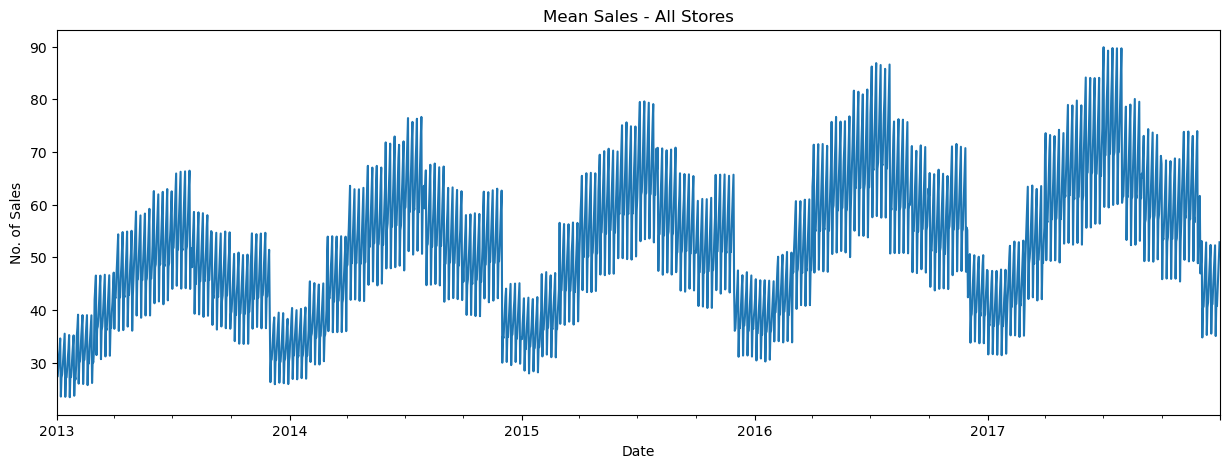

In [42]:
# Set the figure size
plt.figure(figsize=(15, 5))

# plotting
mean_sales.plot()

# title
plt.title('Mean Sales - All Stores')

# xlabel and ylabel
plt.xlabel('Date')
plt.ylabel('No. of Sales')

# saving as a picture
plt.savefig('output/mean_sales_all_stores.png', dpi=300)

plt.show()

We can see there's seasonality in the data. Sales are higher in the middle of the year and lower in the beginning and end of the year. Possibly a northern hemisphere summer seasonal store or southern hemisphere winter store.

Notice that there's a slight upward trend in number of sales with time.

In [16]:
# let's take a look at median sales across all stores
median_sales = df.groupby('date')['sales'].median()

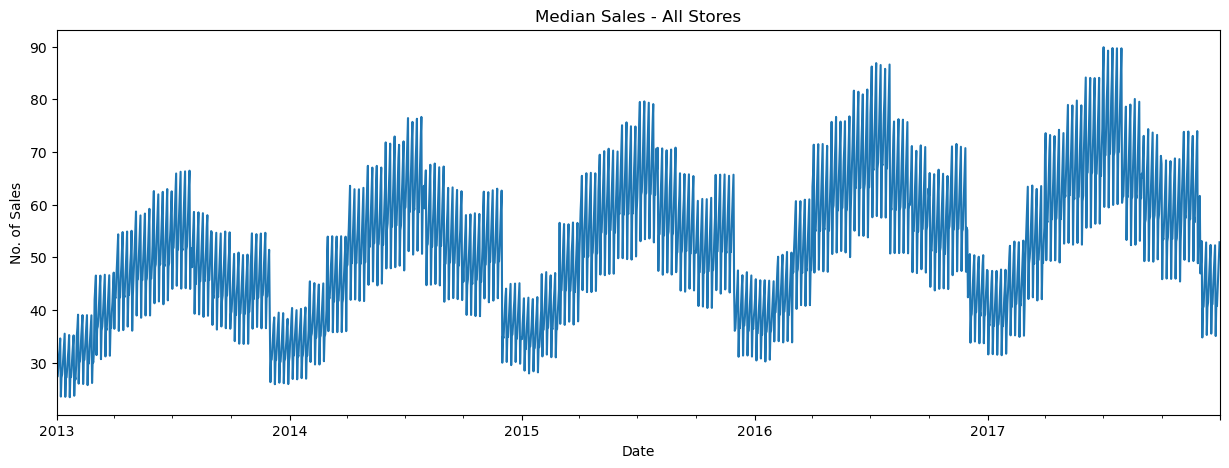

In [43]:
# Set the figure size
plt.figure(figsize=(15, 5))

# plotting
mean_sales.plot()

# title
plt.title('Median Sales - All Stores')

# xlabel and ylabel
plt.xlabel('Date')
plt.ylabel('No. of Sales')

# display the plot
plt.show()

As expected, a similar looking line plot.

In [18]:
# let's zoom into a specific year to have a better look.
onefive = df[(df['date'] >= '2015-01-01') & (df['date'] <= '2015-12-31')]

onefive_mean_sales = onefive.groupby('date')['sales'].mean()

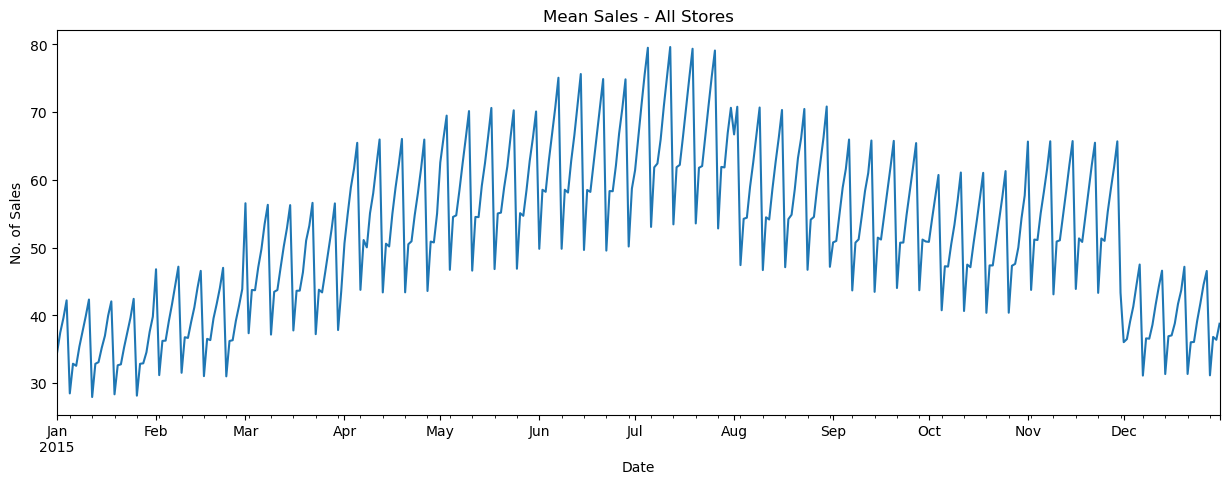

In [19]:
# Set the figure size
plt.figure(figsize=(15, 5))

# plotting mean sales of all stores 2015
onefive_mean_sales.plot()

# title
plt.title('Mean Sales - All Stores')

# xlabel and ylabel
plt.xlabel('Date')
plt.ylabel('No. of Sales')

plt.show()

In terms of monthly trends, it can be seen that Jul and Aug is where the number of sales peak. Jan and Dec see the lowest number of sales. 

An almost weekly rise and dip can be seen - at this granularity level it can be a little hard to make a conclusion. Will try breaking it down into week level to 

In [20]:
# let's try breaking it down into day of week
onefive_df_ind = pd.DataFrame(data=onefive_mean_sales)
onefive_df = onefive_df_ind.reset_index()
onefive_df['dow'] = onefive_df['date'].dt.dayofweek
onefive_df['day_of_week'] = onefive_df['dow'].map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
onefive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         365 non-null    datetime64[ns]
 1   sales        365 non-null    float64       
 2   dow          365 non-null    int32         
 3   day_of_week  365 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 10.1+ KB


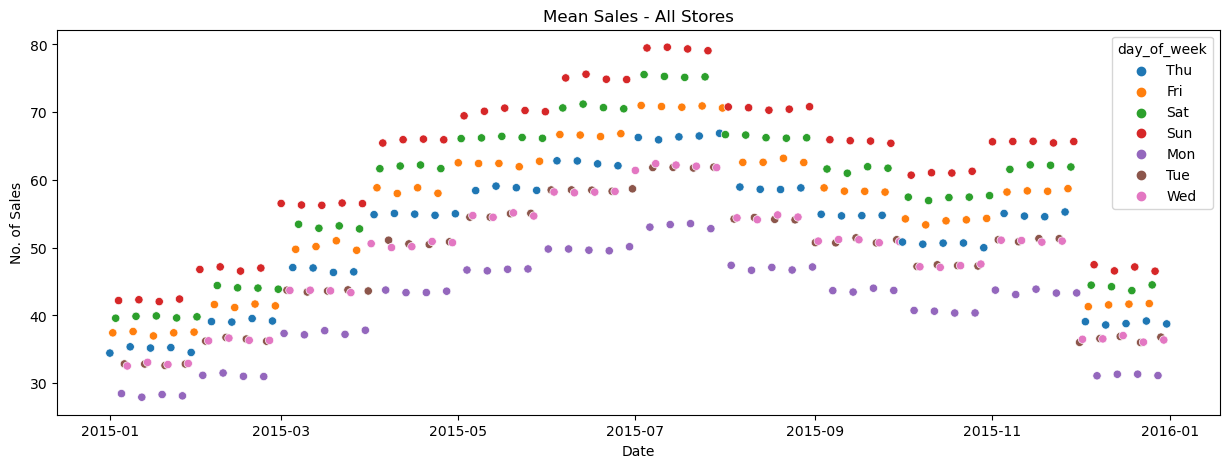

In [44]:
# using seaborn for ease of use

# Set the figure size
plt.figure(figsize=(15, 5))

# Create a scatter plot with color-coded points based on day of week
sns.scatterplot(x='date', y='sales', hue='day_of_week', data=onefive_df)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('No. of Sales')
plt.title('Mean Sales - All Stores')

# save as a picture
plt.savefig('output/mean_sales_all_stores_day_split.png', dpi=300)

# Display the plot
plt.show()

The guess previously was correct, there is a weekly pattern. Sundays see the largest number of sales; Monday sees the lowest. The number of sales increases throughout the week from Monday, peaking on Sunday, then dropping down the a minimum on Monday again. This cycle repeats.

We could do all other sorts of breakdowns to have a better idea about the dataset.

For example:
1. Histogram of the number of daily sales to see the spread.
2. A boxplot of daily sales is useful too.
3. Scatter plot of daily sales by store id.
2. Splitting up the stores to see if stores perform differently.

However, that's not the real point of this exercise here. We're trying to make future predictions.

## Prediction - Prophet Model
Chose to use the prophet model for a few reasons:
1. Ease of use: It's not as difficult to use as ARIMA.
2. Testing prophet for use in another project: Testing the prophet model here using a simpler dataset to get an idea on how to use it. Planning on using it for another project.



### Prediction - Mean Sales of All Stores

In [22]:
# using mean sales first to try out the model
# turning the aggregated series into a dataframe
mean_sales_copy = mean_sales.copy()
mean_sales_df = mean_sales_copy.reset_index(name='sales')

# renaming the columns to ds and y respectively - this is cuz prophet requires the column names to be as such
mean_sales_df.rename(columns={'date':'ds', 'sales':'y'}, inplace=True)

In [23]:
mean_sales_df.describe()

,ds,y
count,1826,1826.000000
mean,2015-07-02 12:00:00.000000256,52.250287
min,2013-01-01 00:00:00,23.418000
25%,2014-04-02 06:00:00,42.390000
50%,2015-07-02 12:00:00,51.679000
75%,2016-09-30 18:00:00,61.559000
max,2017-12-31 00:00:00,89.872000
std,NaN,12.836540


In [24]:
# split into train and test
# let's use 2017 as the test data
train = mean_sales_df[mean_sales_df['ds'] < '2017-01-01']
test = mean_sales_df[['y']][mean_sales_df['ds'] >= '2017-01-01']  #usig only y here cuz sklearn.metrics doesn't understand dates

# define the model
m = Prophet()

# fit the model on the training data
m.fit(train)

# make a future facing dataset for 365 days to forecast out on
# this is a df filled with only dates
future = m.make_future_dataframe(periods=365, freq='d')

# apply the model to the future facing df
forecast = m.predict(future)

14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,44.780446,23.296108,28.770247,44.780446,44.780446,-18.707348,-18.707348,-18.707348,-3.837171,-3.837171,-3.837171,-14.870177,-14.870177,-14.870177,0.0,0.0,0.0,26.073098
1,2013-01-02,44.759441,23.343445,28.922253,44.759441,44.759441,-18.659079,-18.659079,-18.659079,-3.759745,-3.759745,-3.759745,-14.899333,-14.899333,-14.899333,0.0,0.0,0.0,26.100362
2,2013-01-03,44.738435,26.407078,32.146703,44.738435,44.738435,-15.490368,-15.490368,-15.490368,-0.550396,-0.550396,-0.550396,-14.939972,-14.939972,-14.939972,0.0,0.0,0.0,29.248067
3,2013-01-04,44.717430,29.855307,35.605257,44.717430,44.717430,-12.122330,-12.122330,-12.122330,2.867737,2.867737,2.867737,-14.990067,-14.990067,-14.990067,0.0,0.0,0.0,32.595100
4,2013-01-05,44.696425,33.167480,38.692831,44.696425,44.696425,-8.866036,-8.866036,-8.866036,6.181202,6.181202,6.181202,-15.047238,-15.047238,-15.047238,0.0,0.0,0.0,35.830389


Some explanation for the terms:
* The forecasted value (yhat)
* Range for the forecasted values (yhat_lower and yhat_upper)
* The overall trend for a given date (also incorporates seasonality)
* Additive terms to adjust the trend to get the forecasted value

To get the predicted value, you would do the following:
* yhat = trend + additive_terms



/home/admin/anaconda3/lib/python3.11/site-packages/prophet/plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/admin/anaconda3/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


<Figure size 1500x500 with 0 Axes>

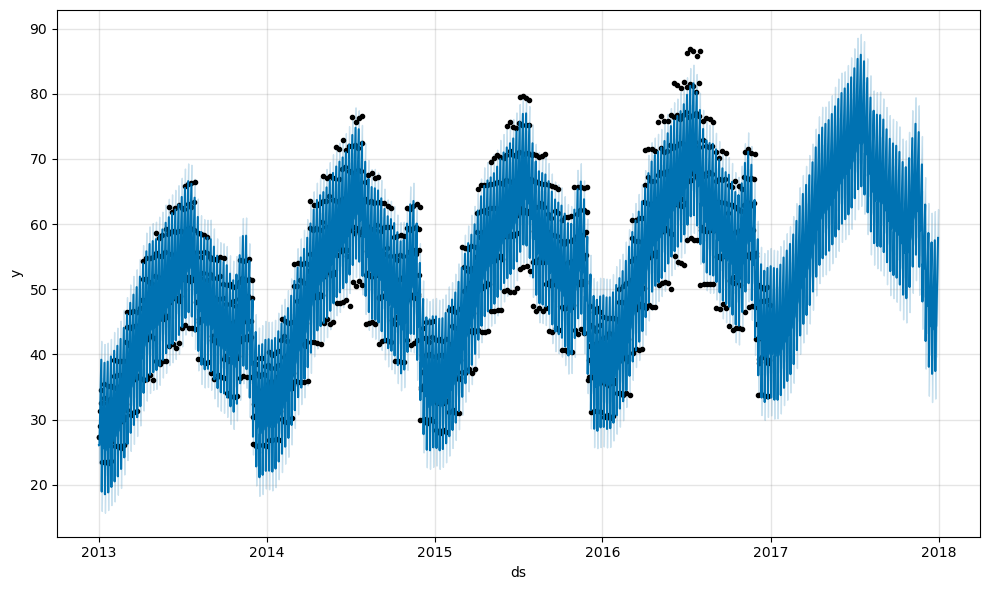

In [26]:
# taking a look at the predicted plot
plt.figure(figsize=(15, 5))
fig1 = m.plot(forecast).savefig('output/mean_sales_forecast.png')  # the .savefig method is an addition to save the figure

The figure above looks like it's a pretty good match to the actual 2017 data. We'll test them later to see how accurate the prediction is

/home/admin/anaconda3/lib/python3.11/site-packages/prophet/plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/admin/anaconda3/lib/python3.11/site-packages/prophet/plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/admin/anaconda3/lib/python3.11/site-packages/prophet/plot.py:352: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

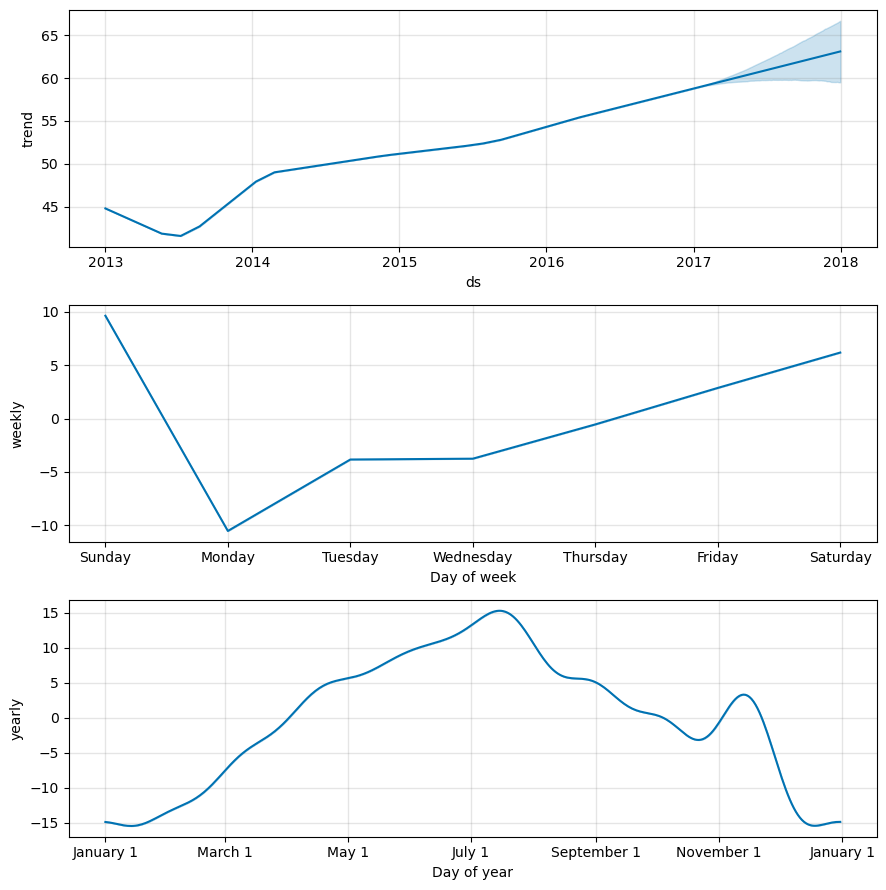

In [27]:
# checking out the forecast components
fig2 = m.plot_components(forecast).savefig('output/mean_sales_forecast_components.png')  # the .savefig method is an addition to save the figure

These 3 plots reinforce what we already can tell about the dataset:
1. Overall increase in the average sales of all stores with time
2. There's a weekly trend in sales where sales increase from Mon to Sun regularly. Weekly sales peak on Sun.
3. There's a yearly trend where July and August see the largest number of sales.

In [28]:
# setting up a new df to test for accuracy with the test set
forecast_2017 = forecast[['yhat']][forecast['ds'] >= '2017-01-01']

# mse
mse = mean_squared_error(test, forecast_2017)

# rmse
rmse = mse**0.5

# mae
mae = mean_absolute_error(test, forecast_2017)

# mape
mape = mean_absolute_percentage_error(test, forecast_2017)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

Mean Squared Error (MSE): 12.5094
Root Mean Squared Error (RMSE): 3.5369
Mean Absolute Error (MAE): 2.9577
Mean Absolute Percentage Error (MAPE): 0.0558


RMSE of 3.53 is considered pretty good since the number of sales range between 12 to 89.

MAE of 2.96 is again, a good sign.

MAPE of 0.0558 (this is 5.58%) is good too - the model has a 94.42% accuracy.

### Prediction - Sales of Store 1
As another sanity check, let's test the model on just store 1 this time. Note that the dataset has 50 distinct stores.

In [29]:
# testing the prophet model on just store 1 this time
# aggregate to just store level first
store_sales = df.groupby(['date', 'store'], as_index=False)['sales'].sum()
store_sales = store_sales.rename(columns={'date':'ds', 'sales':'y'})
store_sales.head()

,ds,store,y
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032


In [30]:
# checking some stats of store_sales
store_sales.describe()

,ds,store,y
count,18260,18260.00000,18260.000000
mean,2015-07-02 11:59:59.999999744,5.50000,2612.514348
min,2013-01-01 00:00:00,1.00000,790.000000
25%,2014-04-02 00:00:00,3.00000,1983.000000
50%,2015-07-02 12:00:00,5.50000,2515.000000
75%,2016-10-01 00:00:00,8.00000,3170.000000
max,2017-12-31 00:00:00,10.00000,5839.000000
std,NaN,2.87236,833.578705


In [31]:
# breaking into train and test
train = store_sales[store_sales['ds'] < '2017-01-01']
test = store_sales[store_sales['ds'] >= '2017-01-01']

In [32]:
# model for store number 1
store_num = 1
train_sub = train[train['store'] == store_num]
test_sub = test[test['store'] == store_num]
test_sub = test_sub.drop(columns=['ds', 'store'])

# define the model as m
m = Prophet()

# fit the model onto the training set
m.fit(train_sub)

# make future facing df for next 365 days
future = m.make_future_dataframe(periods=365, freq='d')

# apply the model to the future facing df
forecast = m.predict(future)

# setting up a new df to test for accuracy with the test set
forecast_2017 = forecast[['yhat']][forecast['ds'] >= '2017-01-01']

# mse
mse = mean_squared_error(test_sub, forecast_2017)

# rmse
rmse = mse**0.5

# mae
mae = mean_absolute_error(test_sub, forecast_2017)

# mape
mape = mean_absolute_percentage_error(test_sub, forecast_2017)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

14:55:37 - cmdstanpy - INFO - Chain [1] start processing
14:55:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (MSE): 30606.0043
Root Mean Squared Error (RMSE): 174.9457
Mean Absolute Error (MAE): 146.7439
Mean Absolute Percentage Error (MAPE): 0.0612


When we look at the sum of sales by stores:
* median number of sales is 2515
* min number of sales is 790
* max number of sales is 5839

From the measures of accuracy calculated above:
* RMSE of 174.95 is pretty good
* MAPE of 0.0612 (6.12%) is good - meaning the model has a 93.88% accuracy for store 1.

In conclusion the prophet model works great for this dataset.

### Prediction - All Stores - One After Another
Mass testing to see what the accuracy of each store is. Expecting most stores to be >90% accurate in terms of MAPE.

In [33]:
# breaking into train and test
train = store_sales[store_sales['ds'] < '2017-01-01']
test = store_sales[store_sales['ds'] >= '2017-01-01']

In [34]:
# making an empty df to store all the relevant info
#results_df = pd.DataFrame(columns=['store_num', 'mse', 'rmse', 'mae', 'mape'])
rows = []

# making a for loop to model and test each store individually
for store_num in train['store'].unique():
  # subset for current store
  train_sub = train[train['store'] == store_num]
  test_sub = test[test['store'] == store_num]
  test_sub = test_sub.drop(columns=['ds', 'store'])

  # define the model as m
  m = Prophet()

  # fit the model onto the training set
  m.fit(train_sub)

  # make future facing df for next 365 days
  future = m.make_future_dataframe(periods=365, freq='d')

  # apply the model to the future facing df
  forecast = m.predict(future)

  # setting up a new df to test for accuracy with the test set
  forecast_2017 = forecast[['yhat']][forecast['ds'] >= '2017-01-01']

  # calculate the measures of error
  mse = mean_squared_error(test_sub, forecast_2017)
  rmse = mse**0.5
  mae = mean_absolute_error(test_sub, forecast_2017)
  mape = mean_absolute_percentage_error(test_sub, forecast_2017)

  # making a list of lists to hold the 5 calculated values of each iteration in its own list
  rows.append([store_num, mse, rmse, mae, mape])

# converting the list of lists into a df
results_df = pd.DataFrame(rows, columns=['store_num', 'mse', 'rmse', 'mae', 'mape'])

14:55:38 - cmdstanpy - INFO - Chain [1] start processing
14:55:38 - cmdstanpy - INFO - Chain [1] done processing
14:55:38 - cmdstanpy - INFO - Chain [1] start processing
14:55:38 - cmdstanpy - INFO - Chain [1] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing
14:55:41 - cmdstanpy - INFO - Chain [1] done processing
14:55:41 - cmdstanpy - INFO - Chain [1] start processing
14:55:42 - cmdstanpy - INFO - Chain [1] done processing
14:55:42 - cmdstanpy - INFO - Chain [1] start processing
14:55:42 - cmdstanpy - INFO - Chain [1] done processing
14:55:43 - cmdstanpy - INFO - Chain [1] start processing
14:55:43 - cmdstanpy - INFO - Chain [1]

In [35]:
# adding an additional column that subtracts mape from 1
results_df['accuracy_rate'] = 1 - results_df['mape']

In [36]:
results_df.head()

,store_num,mse,rmse,mae,mape,accuracy_rate
0,1,30606.004336,174.945718,146.743899,0.061203,0.938797
1,2,60714.138921,246.402392,204.789476,0.060434,0.939566
2,3,38427.592835,196.029571,159.398993,0.052180,0.947820
3,4,41087.918897,202.701551,170.052006,0.061070,0.938930
4,5,22559.349967,150.197703,125.948832,0.062943,0.937057


In [37]:
results_df.describe()

,store_num,mse,rmse,mae,mape,accuracy_rate
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,36147.090309,186.953909,155.431263,0.058918,0.941082
std,3.02765,13675.825190,36.443659,30.255245,0.003169,0.003169
min,1.00000,18583.378013,136.320864,113.040800,0.052180,0.937057
25%,3.25000,24571.013559,156.384707,131.147598,0.057315,0.938830
50%,5.50000,36896.535101,192.043342,159.731594,0.059476,0.940524
75%,7.75000,43401.840658,208.305955,172.675867,0.061170,0.942685
max,10.00000,60714.138921,246.402392,204.789476,0.062943,0.947820


As expected the accuracy of the model for all the stores are high.

Range of values are 93.7% - 94.78%.

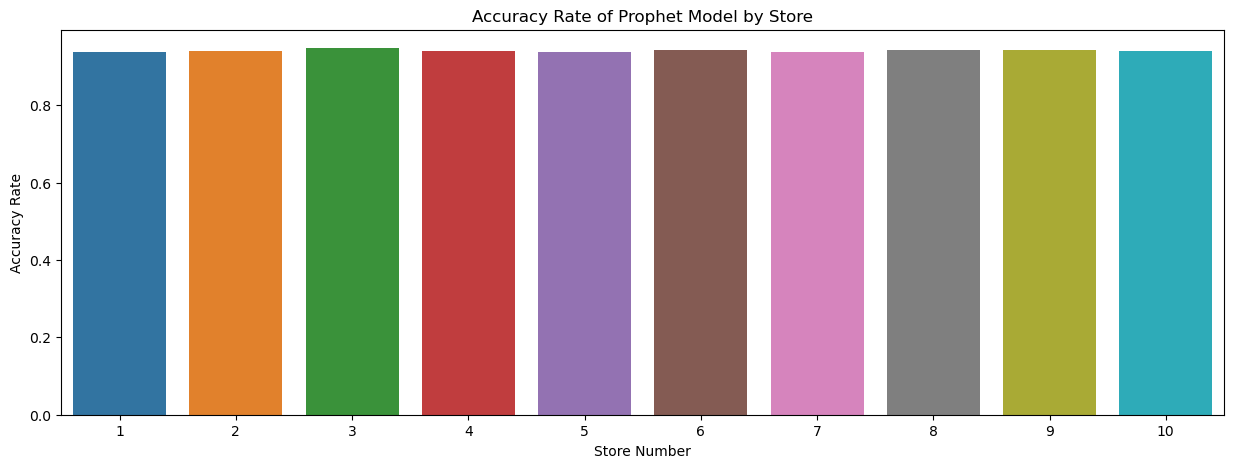

In [45]:
# Set the figure size
plt.figure(figsize=(15, 5))

# Create a scatter plot with color-coded points based on day of week
sns.barplot(x='store_num', y='accuracy_rate', data=results_df)

# Adding labels and title
plt.xlabel('Store Number')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy Rate of Prophet Model by Store')

# save as a picture
plt.savefig('output/accuracy_of_model_by_store.png', dpi=300)

# Display the plot
plt.show()

As we can see from the plot above, the accuracy rate (1-MAPE) is fairly consistent across all stores.

In [39]:
# saving the results df as a csv file
results_df.to_csv('output/results.csv')

## Conclusion
The Prophet model works really well for this usecase. Will need to test in another project to see if it works as well there.

In general, what can be seen is that sales or market related datasets seems to work well with Prophet - since it was designed with these datasets in mind. Will need to test and see if it works for other types of datasets like traffic flow, animal movement patterns, etc.